# 환경 설치

In [63]:
import torch

print(torch.__version__)

1.10.0


conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge
pip install timm==0.4.12
pip install omegaconf
pip install albumentations==1.3.0
pip install scipy
pip install pylibjpeg
pip install pylibjpeg-openjpeg


In [2]:
!nvidia-smi

Sun Oct  9 17:44:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.40       Driver Version: 517.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    16W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc -V # 제 컴퓨터는 cuda 버전이 11.3입니다...

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


# 데이터 준비

In [64]:
import pandas as pd
from tqdm.notebook import tqdm
import os 


In [65]:
DIR_INPUT = 'C:/A/VinBigData/data_dicom'
DIR_TRAIN = f'{DIR_INPUT}/train1000'
DIR_TEST = f'{DIR_INPUT}/test'
DIR_WEIGHTS = 'C:/A/VinBigData/data_dicom/weights'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/model_state_epoch_9.pth'

#데이터 양 조절로 인한 train.csv 파일내 dicom 파일 이름과 실제 dicom 파일간의 불일치 문제 해소
# trian 파일내에 존재하는 dicom 파일로만 이루어진 데이터 프레임을 생성

file_dir= os.listdir('C:/A/VinBigData/data_dicom/train1000')
train_df = pd.read_csv('C:/A/VinBigData/data_dicom/train.csv')


In [66]:
# 현재 가지고있는 test 데이터로만 활용(원활한 학습을 위해 데이터량줄임)
import os
file_list = os.listdir(DIR_TRAIN)
print(len(file_list))

file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    else:
        for k in range(len(file)-1,0,-1):
            if file[k]=='.':
                file_name.append(file[:k])
                break
                
print(len(file_name))

1000
1000


In [67]:
len(train_df)

67914

In [68]:
train_df = train_df[train_df['image_id'].isin(file_name)]
print(len(train_df))


4530


In [69]:
len(train_df)

4530

In [70]:
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
34,2b1293d9c276e5439e499f58ce2e31ab,No finding,14,R8,NaN,NaN,NaN,NaN
68,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0
69,0a14aeaf02d42990d8bb5d55270b7274,ILD,5,R9,593.0,1597.0,1111.0,2207.0
...,...,...,...,...,...,...,...,...
67825,0abd4fc2425edd5c2efb2c149e9319c6,Pleural thickening,11,R10,795.0,318.0,1095.0,453.0
67841,2be0cff9073424bcaf946885d1c1adf5,Aortic enlargement,0,R10,1098.0,739.0,1352.0,1001.0
67842,1ed4cf45940bbfbcdc31cf4289c1c1e4,Aortic enlargement,0,R10,1416.0,741.0,1719.0,983.0
67850,2ba09f4a64b4d6268cf891974fa9bad9,No finding,14,R15,NaN,NaN,NaN,NaN


# import

In [71]:
import sys
import re
import os
from datetime import datetime
import random
import time
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [72]:
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
import pydicom
import warnings
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

In [73]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

In [74]:
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
34,2b1293d9c276e5439e499f58ce2e31ab,No finding,14,R8,NaN,NaN,NaN,NaN
68,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0
69,0a14aeaf02d42990d8bb5d55270b7274,ILD,5,R9,593.0,1597.0,1111.0,2207.0
...,...,...,...,...,...,...,...,...
67825,0abd4fc2425edd5c2efb2c149e9319c6,Pleural thickening,11,R10,795.0,318.0,1095.0,453.0
67841,2be0cff9073424bcaf946885d1c1adf5,Aortic enlargement,0,R10,1098.0,739.0,1352.0,1001.0
67842,1ed4cf45940bbfbcdc31cf4289c1c1e4,Aortic enlargement,0,R10,1416.0,741.0,1719.0,983.0
67850,2ba09f4a64b4d6268cf891974fa9bad9,No finding,14,R15,NaN,NaN,NaN,NaN


In [75]:
df = train_df[train_df['class_name'] != 'No finding']
df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
68,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0
69,0a14aeaf02d42990d8bb5d55270b7274,ILD,5,R9,593.0,1597.0,1111.0,2207.0
100,2d063af5457785f5c76ae1e6c06c0037,Pleural thickening,11,R9,1144.0,338.0,1433.0,440.0
...,...,...,...,...,...,...,...,...
67775,01fec681f2d698497151a88d6c5205a1,Pleural thickening,11,R9,1413.0,226.0,1822.0,374.0
67812,0a2d01ecb9e01cf972c1e1d31ccacb98,Cardiomegaly,3,R10,852.0,1473.0,1796.0,1804.0
67825,0abd4fc2425edd5c2efb2c149e9319c6,Pleural thickening,11,R10,795.0,318.0,1095.0,453.0
67841,2be0cff9073424bcaf946885d1c1adf5,Aortic enlargement,0,R10,1098.0,739.0,1352.0,1001.0


In [76]:
#현재 Not find(15번째 class)를 제외했기 때문에 총 14개의 class가 남아있다
N_CLASSES = 14

#GPU 하나에만 연산 할당
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [77]:
#StratifiedKFold 기법:
# 불균형한 DataSet을 위한 KFold 방법
# 각 클래스의 특정 퍼센트를 유지한 체 나눈다
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
df_folds = df[['image_id']].copy()

df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'object_count'] = df.groupby('image_id')['class_id'].nunique()

df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['object_count'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 14}').values.astype(str)
)

df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number


In [78]:
df_folds

,bbox_count,object_count,stratify_group,fold
image_id,,,,
000d68e42b71d3eac10ccc077aba07c1,16,5,5_1,0
001d127bad87592efe45a5c7678f8b8d,6,2,2_0,3
00aca42a24e4ea6066cca2546150c36e,9,5,5_0,2
00bcb82818ea83d6a86df241762cd7d0,5,5,5_0,2
00f2f97f74e086e1f82acc285ee4a5c5,8,5,5_0,1
...,...,...,...,...
2dae0b56a64f3708706e63711d970243,10,4,4_0,2
2dd5e1ec060f1389e24a4caffa6d534e,18,5,5_1,4
2de0585a5eea24c7e8672fcd70da26b4,3,1,1_0,4


In [79]:
df_folds.reset_index(inplace=True)
df_folds

,image_id,bbox_count,object_count,stratify_group,fold
0,000d68e42b71d3eac10ccc077aba07c1,16,5,5_1,0
1,001d127bad87592efe45a5c7678f8b8d,6,2,2_0,3
2,00aca42a24e4ea6066cca2546150c36e,9,5,5_0,2
3,00bcb82818ea83d6a86df241762cd7d0,5,5,5_0,2
4,00f2f97f74e086e1f82acc285ee4a5c5,8,5,5_0,1
...,...,...,...,...,...
295,2dae0b56a64f3708706e63711d970243,10,4,4_0,2
296,2dd5e1ec060f1389e24a4caffa6d534e,18,5,5_1,4
297,2de0585a5eea24c7e8672fcd70da26b4,3,1,1_0,4
298,2df96190b0062c04b4dad588079c4caf,12,4,4_0,4


In [80]:
#Train, valid 두개로 나눔
valid_df = pd.merge(df, df_folds[df_folds['fold'] == 0], on='image_id')
train_df = pd.merge(df, df_folds[df_folds['fold'] != 0], on='image_id')

In [81]:
df_folds

,image_id,bbox_count,object_count,stratify_group,fold
0,000d68e42b71d3eac10ccc077aba07c1,16,5,5_1,0
1,001d127bad87592efe45a5c7678f8b8d,6,2,2_0,3
2,00aca42a24e4ea6066cca2546150c36e,9,5,5_0,2
3,00bcb82818ea83d6a86df241762cd7d0,5,5,5_0,2
4,00f2f97f74e086e1f82acc285ee4a5c5,8,5,5_0,1
...,...,...,...,...,...
295,2dae0b56a64f3708706e63711d970243,10,4,4_0,2
296,2dd5e1ec060f1389e24a4caffa6d534e,18,5,5_1,4
297,2de0585a5eea24c7e8672fcd70da26b4,3,1,1_0,4
298,2df96190b0062c04b4dad588079c4caf,12,4,4_0,4


In [82]:
len(list(set(valid_df['image_id']))),len(list(set(train_df['image_id'])))

(60, 240)

In [83]:
train_df


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,bbox_count,object_count,stratify_group,fold
0,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,9,2,2_0,3
1,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R9,511.0,508.0,950.0,762.0,9,2,2_0,3
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,1780.0,361.0,2047.0,612.0,9,2,2_0,3
3,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R9,1793.0,757.0,1972.0,917.0,9,2,2_0,3
4,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R8,1684.0,450.0,1916.0,739.0,9,2,2_0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1936,1f68a73472d32146d1cbe3bcd9355337,Pleural effusion,10,R8,274.0,269.0,1240.0,1935.0,3,1,1_0,1
1937,1f68a73472d32146d1cbe3bcd9355337,Pleural effusion,10,R9,335.0,257.0,1315.0,2176.0,3,1,1_0,1
1938,0f26e889539ff64afd23927ee40436b8,Cardiomegaly,3,R9,1177.0,1667.0,2450.0,2384.0,3,1,1_0,2
1939,0f26e889539ff64afd23927ee40436b8,Cardiomegaly,3,R8,1163.0,1598.0,2425.0,2384.0,3,1,1_0,2


In [84]:
valid_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,bbox_count,object_count,stratify_group,fold
0,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,5,2,2_0,0
1,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R10,1180.0,741.0,1453.0,1018.0,5,2,2_0,0
2,0cfae3f740f87ca3b96dec765d06fad0,Pulmonary fibrosis,13,R10,441.0,1300.0,583.0,1424.0,5,2,2_0,0
3,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R8,1181.0,736.0,1448.0,1114.0,5,2,2_0,0
4,0cfae3f740f87ca3b96dec765d06fad0,Pulmonary fibrosis,13,R9,423.0,1306.0,834.0,1541.0,5,2,2_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
484,2beb474652da324c06ca0267cc903c1e,Cardiomegaly,3,R10,521.0,1443.0,1992.0,1899.0,6,2,2_0,0
485,2beb474652da324c06ca0267cc903c1e,Aortic enlargement,0,R10,1048.0,702.0,1508.0,1131.0,6,2,2_0,0
486,2beb474652da324c06ca0267cc903c1e,Aortic enlargement,0,R8,1108.0,708.0,1512.0,1143.0,6,2,2_0,0
487,2beb474652da324c06ca0267cc903c1e,Cardiomegaly,3,R8,611.0,1279.0,1922.0,1885.0,6,2,2_0,0


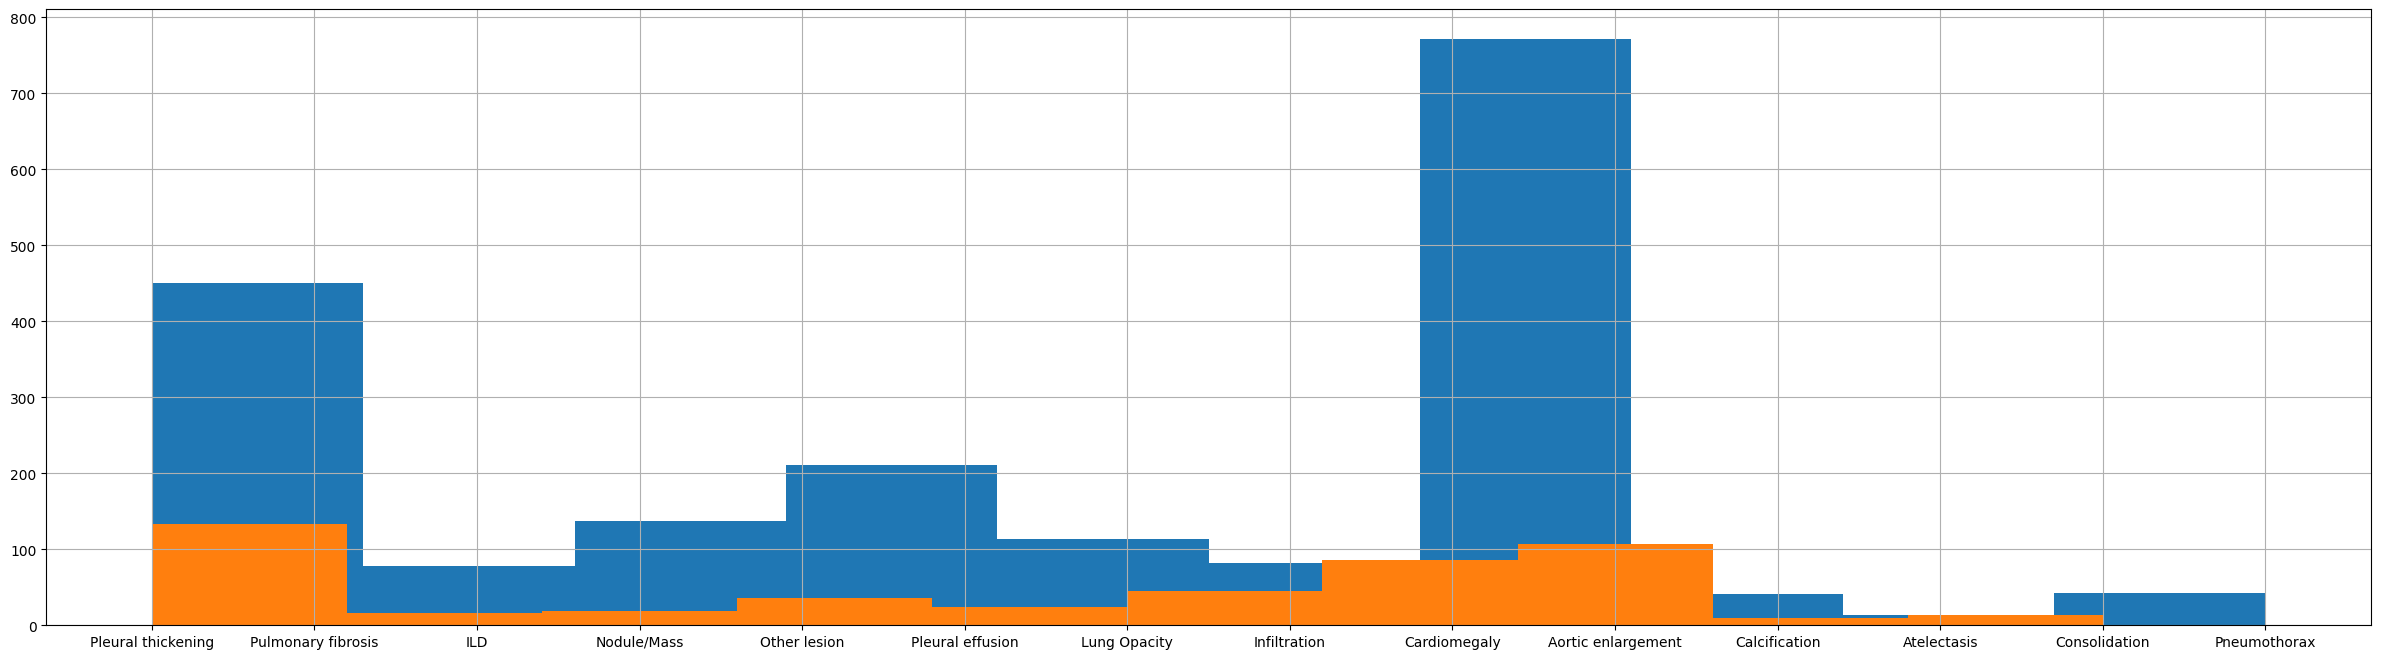

In [85]:
figure(num=None, figsize=(30, 8))
train_df['class_name'].hist()
valid_df['class_name'].hist()
plt.show()

In [86]:
def get_train_transforms():
    return A.Compose(
        [
            A.ToGray(p=0.01), #RGB를 Gray Scale로 변환
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),#이미지 크기 변환
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),#64x64크기로 잘라낸다
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc', # object detection의 데이터셋
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [87]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_dir=None, transforms=None):
        super().__init__()

        self.image_ids = marking["image_id"].unique()#train에 사용할 dicom 파일의 이름
        self.marking = marking#train_df
        self.image_dir = image_dir#train에 사용할 dicom파일이 저장된 폴더의 경로
        self.transforms = transforms#get_train_transforms 함수의 return 값

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        records = self.marking[(self.marking['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        #marking(train_df, test_df)에서 일부만 발췌해서 records에 저장
        image, boxes = self.load_image_and_boxes(index)

        labels = records["class_id"].values
        target = {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels), 'image_id': torch.tensor([index])}

        if self.transforms:
            sample = self.transforms(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            })
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'][:, [0, 1, 2, 3]] = target['boxes'][:, [1, 0, 3, 2]]
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        #Photometric interpretation = dicom 이미지의 visualization 관련 정보
        #MONOCHROME1 = pixel이 하얀색으로 나타나는 gray scale image
        #MONOCHROME2 = pixel이 검은색으로 나타나는 gray scale image
        #RGB = 컬러 이미지
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image

        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image.transpose(1, 2, 0)

        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        return image, boxes #이미지를 array형태로 box의 두 x좌표와 y좌표를 반환한다

In [88]:
image_paths = DIR_TRAIN
train_dataset = DatasetRetriever(
    marking=train_df,
    image_dir=image_paths,
    transforms=get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    marking=valid_df,
    image_dir=image_paths,
    transforms=get_valid_transforms(),
)

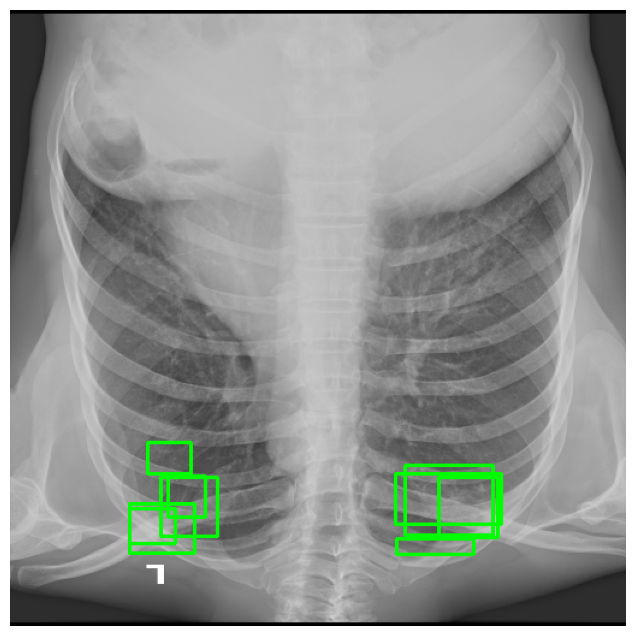

In [89]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int64)

numpy_image = image.permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2)

ax.set_axis_off()
ax.imshow(numpy_image)
plt.show()

In [90]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [112]:
#학습을 위한 코드
class Fitter:
  # config = 학습에 필요한 정보(batch_size, epoch 수, learning rate, verbose(학습 상황을 표시할지 말지(1이면 하고 0이면 안함)), optimizer)

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}' #해당 코드에서는 logging_path
        if not os.path.exists(self.base_dir):#/content/logging_path 폴더를 생성 해당 폴더에 weights를 저장한다
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        # 모델을 이루는 파라미터 접근 방법:
        #   parameter() = layer 이름을 제외한 parameter 값 출력
        #   named_parameters() = (layer 이름, parameter 값)조합을 tuple 형태로 출력
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        # reproducing the behavior of the original optimizer = optimizer의 행동을 재현
        # 사용 이유: 연산 속도 향상(추정)
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        #AdamW를 optimizer로 사용
        # AdamW와 Adam의 차이
        # AdamW = weight decay 위한 텀 수식이 추가된 Adam
        # weight decay: 
        #   loss function을 줄여 overfitting 문제를 막기 위한 방법
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                #최고 weight 마지막 weight를 저장
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                    
                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            self.optimizer.zero_grad()
            
            print('test',len(images))
            
            loss, _, _ = self.model(images, boxes, labels)

            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [119]:
class TrainGlobalConfig:
    num_workers = 1
    batch_size = 8
    folder = 'logging_path'
    n_epochs = 1
    lr = 0.0002
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    #val_loss가 향상되지 않을 때, learning rate를 factor(현 모델에선 0.5)배로 감소시킨다
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )

In [120]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [121]:
def run_training():
    net.to(device)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [122]:
# !unzip -q /content/drive/MyDrive/efficientdet_d4-5b370b7a.pth.zip
# https://github.com/rwightman/efficientdet-pytorch/releases/tag/v0.1

In [123]:
#3
def get_net():
  #effidet.config에서 import해온 함수
  # omegaconfig = 프로그램 설정 정보를 가져오는 모듈
  # efficeientdet_d4의 기본 설정 정보를 가져온다
  # bakcbone = 구조 = tf_efficientdet_d4
    
    config = get_efficientdet_config(model_name='tf_efficientdet_lite3')
    config.image_size = [512,512]
    config.norm_kwargs=dict(eps=.001, momentum=.01)
    
    net = EfficientDet(config, pretrained_backbone=False)

    checkpoint = torch.load('C:/A/VinBigData/tf_efficientdet_lite3-506852cb.pth')
    net.load_state_dict(checkpoint)

    
    net.reset_head(num_classes=14)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, config)
  
net = get_net()


In [124]:
run_training()

Fitter prepared. Device is cuda

2022-10-09T09:10:12.933169
LR: 0.0002


# 에러 해결 시도
https://www.kaggle.com/code/shonenkov/training-efficientdet/comments

In [ ]:
#1
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('C:/A/VinBigData/tf_efficientdet_d4-5b370b7a.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 14
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()


RuntimeError: Error(s) in loading state_dict for EfficientDet:
	Missing key(s) in state_dict: "backbone.blocks.0.2.conv_dw.weight", "backbone.blocks.0.2.bn1.weight", "backbone.blocks.0.2.bn1.bias", "backbone.blocks.0.2.bn1.running_mean", "backbone.blocks.0.2.bn1.running_var", "backbone.blocks.0.2.se.conv_reduce.weight", "backbone.blocks.0.2.se.conv_reduce.bias", "backbone.blocks.0.2.se.conv_expand.weight", "backbone.blocks.0.2.se.conv_expand.bias", "backbone.blocks.0.2.conv_pw.weight", "backbone.blocks.0.2.bn2.weight", "backbone.blocks.0.2.bn2.bias", "backbone.blocks.0.2.bn2.running_mean", "backbone.blocks.0.2.bn2.running_var", "backbone.blocks.1.4.conv_pw.weight", "backbone.blocks.1.4.bn1.weight", "backbone.blocks.1.4.bn1.bias", "backbone.blocks.1.4.bn1.running_mean", "backbone.blocks.1.4.bn1.running_var", "backbone.blocks.1.4.conv_dw.weight", "backbone.blocks.1.4.bn2.weight", "backbone.blocks.1.4.bn2.bias", "backbone.blocks.1.4.bn2.running_mean", "backbone.blocks.1.4.bn2.running_var", "backbone.blocks.1.4.se.conv_reduce.weight", "backbone.blocks.1.4.se.conv_reduce.bias", "backbone.blocks.1.4.se.conv_expand.weight", "backbone.blocks.1.4.se.conv_expand.bias", "backbone.blocks.1.4.conv_pwl.weight", "backbone.blocks.1.4.bn3.weight", "backbone.blocks.1.4.bn3.bias", "backbone.blocks.1.4.bn3.running_mean", "backbone.blocks.1.4.bn3.running_var", "backbone.blocks.2.4.conv_pw.weight", "backbone.blocks.2.4.bn1.weight", "backbone.blocks.2.4.bn1.bias", "backbone.blocks.2.4.bn1.running_mean", "backbone.blocks.2.4.bn1.running_var", "backbone.blocks.2.4.conv_dw.weight", "backbone.blocks.2.4.bn2.weight", "backbone.blocks.2.4.bn2.bias", "backbone.blocks.2.4.bn2.running_mean", "backbone.blocks.2.4.bn2.running_var", "backbone.blocks.2.4.se.conv_reduce.weight", "backbone.blocks.2.4.se.conv_reduce.bias", "backbone.blocks.2.4.se.conv_expand.weight", "backbone.blocks.2.4.se.conv_expand.bias", "backbone.blocks.2.4.conv_pwl.weight", "backbone.blocks.2.4.bn3.weight", "backbone.blocks.2.4.bn3.bias", "backbone.blocks.2.4.bn3.running_mean", "backbone.blocks.2.4.bn3.running_var", "backbone.blocks.3.6.conv_pw.weight", "backbone.blocks.3.6.bn1.weight", "backbone.blocks.3.6.bn1.bias", "backbone.blocks.3.6.bn1.running_mean", "backbone.blocks.3.6.bn1.running_var", "backbone.blocks.3.6.conv_dw.weight", "backbone.blocks.3.6.bn2.weight", "backbone.blocks.3.6.bn2.bias", "backbone.blocks.3.6.bn2.running_mean", "backbone.blocks.3.6.bn2.running_var", "backbone.blocks.3.6.se.conv_reduce.weight", "backbone.blocks.3.6.se.conv_reduce.bias", "backbone.blocks.3.6.se.conv_expand.weight", "backbone.blocks.3.6.se.conv_expand.bias", "backbone.blocks.3.6.conv_pwl.weight", "backbone.blocks.3.6.bn3.weight", "backbone.blocks.3.6.bn3.bias", "backbone.blocks.3.6.bn3.running_mean", "backbone.blocks.3.6.bn3.running_var", "backbone.blocks.4.6.conv_pw.weight", "backbone.blocks.4.6.bn1.weight", "backbone.blocks.4.6.bn1.bias", "backbone.blocks.4.6.bn1.running_mean", "backbone.blocks.4.6.bn1.running_var", "backbone.blocks.4.6.conv_dw.weight", "backbone.blocks.4.6.bn2.weight", "backbone.blocks.4.6.bn2.bias", "backbone.blocks.4.6.bn2.running_mean", "backbone.blocks.4.6.bn2.running_var", "backbone.blocks.4.6.se.conv_reduce.weight", "backbone.blocks.4.6.se.conv_reduce.bias", "backbone.blocks.4.6.se.conv_expand.weight", "backbone.blocks.4.6.se.conv_expand.bias", "backbone.blocks.4.6.conv_pwl.weight", "backbone.blocks.4.6.bn3.weight", "backbone.blocks.4.6.bn3.bias", "backbone.blocks.4.6.bn3.running_mean", "backbone.blocks.4.6.bn3.running_var", "backbone.blocks.5.8.conv_pw.weight", "backbone.blocks.5.8.bn1.weight", "backbone.blocks.5.8.bn1.bias", "backbone.blocks.5.8.bn1.running_mean", "backbone.blocks.5.8.bn1.running_var", "backbone.blocks.5.8.conv_dw.weight", "backbone.blocks.5.8.bn2.weight", "backbone.blocks.5.8.bn2.bias", "backbone.blocks.5.8.bn2.running_mean", "backbone.blocks.5.8.bn2.running_var", "backbone.blocks.5.8.se.conv_reduce.weight", "backbone.blocks.5.8.se.conv_reduce.bias", "backbone.blocks.5.8.se.conv_expand.weight", "backbone.blocks.5.8.se.conv_expand.bias", "backbone.blocks.5.8.conv_pwl.weight", "backbone.blocks.5.8.bn3.weight", "backbone.blocks.5.8.bn3.bias", "backbone.blocks.5.8.bn3.running_mean", "backbone.blocks.5.8.bn3.running_var", "backbone.blocks.6.2.conv_pw.weight", "backbone.blocks.6.2.bn1.weight", "backbone.blocks.6.2.bn1.bias", "backbone.blocks.6.2.bn1.running_mean", "backbone.blocks.6.2.bn1.running_var", "backbone.blocks.6.2.conv_dw.weight", "backbone.blocks.6.2.bn2.weight", "backbone.blocks.6.2.bn2.bias", "backbone.blocks.6.2.bn2.running_mean", "backbone.blocks.6.2.bn2.running_var", "backbone.blocks.6.2.se.conv_reduce.weight", "backbone.blocks.6.2.se.conv_reduce.bias", "backbone.blocks.6.2.se.conv_expand.weight", "backbone.blocks.6.2.se.conv_expand.bias", "backbone.blocks.6.2.conv_pwl.weight", "backbone.blocks.6.2.bn3.weight", "backbone.blocks.6.2.bn3.bias", "backbone.blocks.6.2.bn3.running_mean", "backbone.blocks.6.2.bn3.running_var". 
	size mismatch for backbone.blocks.1.0.conv_pwl.weight: copying a param with shape torch.Size([32, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 144, 1, 1]).
	size mismatch for backbone.blocks.1.0.bn3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.0.bn3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.0.bn3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.0.bn3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.conv_pw.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for backbone.blocks.1.1.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.conv_dw.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for backbone.blocks.1.1.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.se.conv_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for backbone.blocks.1.1.se.conv_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for backbone.blocks.1.1.se.conv_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for backbone.blocks.1.1.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.1.conv_pwl.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for backbone.blocks.1.1.bn3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.1.bn3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.2.conv_pw.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for backbone.blocks.1.2.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.conv_dw.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for backbone.blocks.1.2.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.se.conv_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for backbone.blocks.1.2.se.conv_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for backbone.blocks.1.2.se.conv_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for backbone.blocks.1.2.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.2.conv_pwl.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for backbone.blocks.1.2.bn3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.2.bn3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.2.bn3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.2.bn3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.3.conv_pw.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for backbone.blocks.1.3.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.conv_dw.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for backbone.blocks.1.3.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.se.conv_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for backbone.blocks.1.3.se.conv_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for backbone.blocks.1.3.se.conv_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for backbone.blocks.1.3.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.1.3.conv_pwl.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for backbone.blocks.1.3.bn3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.3.bn3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.3.bn3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.1.3.bn3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for backbone.blocks.2.0.conv_pw.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for backbone.blocks.2.0.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.conv_dw.weight: copying a param with shape torch.Size([192, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 5, 5]).
	size mismatch for backbone.blocks.2.0.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.se.conv_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for backbone.blocks.2.0.se.conv_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for backbone.blocks.2.0.se.conv_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for backbone.blocks.2.0.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for backbone.blocks.2.0.conv_pwl.weight: copying a param with shape torch.Size([56, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 240, 1, 1]).
	size mismatch for backbone.blocks.2.0.bn3.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.0.bn3.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.0.bn3.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.0.bn3.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.1.conv_pw.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 64, 1, 1]).
	size mismatch for backbone.blocks.2.1.bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.conv_dw.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([384, 1, 5, 5]).
	size mismatch for backbone.blocks.2.1.bn2.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.bn2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.bn2.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.bn2.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.se.conv_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 384, 1, 1]).
	size mismatch for backbone.blocks.2.1.se.conv_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.2.1.se.conv_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 16, 1, 1]).
	size mismatch for backbone.blocks.2.1.se.conv_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.1.conv_pwl.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 384, 1, 1]).
	size mismatch for backbone.blocks.2.1.bn3.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.1.bn3.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.1.bn3.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.1.bn3.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.2.conv_pw.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 64, 1, 1]).
	size mismatch for backbone.blocks.2.2.bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.conv_dw.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([384, 1, 5, 5]).
	size mismatch for backbone.blocks.2.2.bn2.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.bn2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.bn2.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.bn2.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.se.conv_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 384, 1, 1]).
	size mismatch for backbone.blocks.2.2.se.conv_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.2.2.se.conv_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 16, 1, 1]).
	size mismatch for backbone.blocks.2.2.se.conv_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.2.conv_pwl.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 384, 1, 1]).
	size mismatch for backbone.blocks.2.2.bn3.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.2.bn3.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.2.bn3.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.2.bn3.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.3.conv_pw.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 64, 1, 1]).
	size mismatch for backbone.blocks.2.3.bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.conv_dw.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([384, 1, 5, 5]).
	size mismatch for backbone.blocks.2.3.bn2.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.bn2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.bn2.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.bn2.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.se.conv_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 384, 1, 1]).
	size mismatch for backbone.blocks.2.3.se.conv_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.2.3.se.conv_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 16, 1, 1]).
	size mismatch for backbone.blocks.2.3.se.conv_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.3.conv_pwl.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 384, 1, 1]).
	size mismatch for backbone.blocks.2.3.bn3.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.3.bn3.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.3.bn3.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.2.3.bn3.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for backbone.blocks.3.0.conv_pw.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 64, 1, 1]).
	size mismatch for backbone.blocks.3.0.bn1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.bn1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.bn1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.bn1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.conv_dw.weight: copying a param with shape torch.Size([336, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([384, 1, 3, 3]).
	size mismatch for backbone.blocks.3.0.bn2.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.bn2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.bn2.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.bn2.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.se.conv_reduce.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 384, 1, 1]).
	size mismatch for backbone.blocks.3.0.se.conv_reduce.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for backbone.blocks.3.0.se.conv_expand.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 16, 1, 1]).
	size mismatch for backbone.blocks.3.0.se.conv_expand.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.0.conv_pwl.weight: copying a param with shape torch.Size([112, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 384, 1, 1]).
	size mismatch for backbone.blocks.3.0.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.0.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.0.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.0.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.1.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for backbone.blocks.3.1.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([768, 1, 3, 3]).
	size mismatch for backbone.blocks.3.1.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for backbone.blocks.3.1.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for backbone.blocks.3.1.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for backbone.blocks.3.1.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.1.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 768, 1, 1]).
	size mismatch for backbone.blocks.3.1.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.1.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.1.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.1.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.2.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for backbone.blocks.3.2.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([768, 1, 3, 3]).
	size mismatch for backbone.blocks.3.2.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for backbone.blocks.3.2.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for backbone.blocks.3.2.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for backbone.blocks.3.2.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.2.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 768, 1, 1]).
	size mismatch for backbone.blocks.3.2.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.2.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.2.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.2.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.3.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for backbone.blocks.3.3.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([768, 1, 3, 3]).
	size mismatch for backbone.blocks.3.3.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for backbone.blocks.3.3.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for backbone.blocks.3.3.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for backbone.blocks.3.3.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.3.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 768, 1, 1]).
	size mismatch for backbone.blocks.3.3.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.3.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.3.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.3.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.4.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for backbone.blocks.3.4.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([768, 1, 3, 3]).
	size mismatch for backbone.blocks.3.4.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for backbone.blocks.3.4.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for backbone.blocks.3.4.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for backbone.blocks.3.4.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.4.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 768, 1, 1]).
	size mismatch for backbone.blocks.3.4.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.4.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.4.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.4.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.5.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for backbone.blocks.3.5.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([768, 1, 3, 3]).
	size mismatch for backbone.blocks.3.5.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for backbone.blocks.3.5.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for backbone.blocks.3.5.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for backbone.blocks.3.5.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.3.5.conv_pwl.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 768, 1, 1]).
	size mismatch for backbone.blocks.3.5.bn3.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.5.bn3.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.5.bn3.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.3.5.bn3.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.4.0.conv_pw.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for backbone.blocks.4.0.bn1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.bn1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.bn1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.bn1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.conv_dw.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([768, 1, 5, 5]).
	size mismatch for backbone.blocks.4.0.bn2.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.bn2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.bn2.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.bn2.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.se.conv_reduce.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for backbone.blocks.4.0.se.conv_reduce.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for backbone.blocks.4.0.se.conv_expand.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for backbone.blocks.4.0.se.conv_expand.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for backbone.blocks.4.0.conv_pwl.weight: copying a param with shape torch.Size([160, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([176, 768, 1, 1]).
	size mismatch for backbone.blocks.4.0.bn3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.0.bn3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.0.bn3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.0.bn3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.1.conv_pw.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 176, 1, 1]).
	size mismatch for backbone.blocks.4.1.bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.conv_dw.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1056, 1, 5, 5]).
	size mismatch for backbone.blocks.4.1.bn2.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.bn2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.bn2.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.bn2.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.se.conv_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([44, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.1.se.conv_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([44]).
	size mismatch for backbone.blocks.4.1.se.conv_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 44, 1, 1]).
	size mismatch for backbone.blocks.4.1.se.conv_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.1.conv_pwl.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([176, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.1.bn3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.1.bn3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.1.bn3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.1.bn3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.2.conv_pw.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 176, 1, 1]).
	size mismatch for backbone.blocks.4.2.bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.conv_dw.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1056, 1, 5, 5]).
	size mismatch for backbone.blocks.4.2.bn2.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.bn2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.bn2.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.bn2.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.se.conv_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([44, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.2.se.conv_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([44]).
	size mismatch for backbone.blocks.4.2.se.conv_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 44, 1, 1]).
	size mismatch for backbone.blocks.4.2.se.conv_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.2.conv_pwl.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([176, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.2.bn3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.2.bn3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.2.bn3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.2.bn3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.3.conv_pw.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 176, 1, 1]).
	size mismatch for backbone.blocks.4.3.bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.conv_dw.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1056, 1, 5, 5]).
	size mismatch for backbone.blocks.4.3.bn2.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.bn2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.bn2.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.bn2.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.se.conv_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([44, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.3.se.conv_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([44]).
	size mismatch for backbone.blocks.4.3.se.conv_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 44, 1, 1]).
	size mismatch for backbone.blocks.4.3.se.conv_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.3.conv_pwl.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([176, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.3.bn3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.3.bn3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.3.bn3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.3.bn3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.4.conv_pw.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 176, 1, 1]).
	size mismatch for backbone.blocks.4.4.bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.conv_dw.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1056, 1, 5, 5]).
	size mismatch for backbone.blocks.4.4.bn2.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.bn2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.bn2.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.bn2.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.se.conv_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([44, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.4.se.conv_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([44]).
	size mismatch for backbone.blocks.4.4.se.conv_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 44, 1, 1]).
	size mismatch for backbone.blocks.4.4.se.conv_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.4.conv_pwl.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([176, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.4.bn3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.4.bn3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.4.bn3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.4.bn3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.5.conv_pw.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 176, 1, 1]).
	size mismatch for backbone.blocks.4.5.bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.conv_dw.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1056, 1, 5, 5]).
	size mismatch for backbone.blocks.4.5.bn2.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.bn2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.bn2.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.bn2.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.se.conv_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([44, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.5.se.conv_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([44]).
	size mismatch for backbone.blocks.4.5.se.conv_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 44, 1, 1]).
	size mismatch for backbone.blocks.4.5.se.conv_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.4.5.conv_pwl.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([176, 1056, 1, 1]).
	size mismatch for backbone.blocks.4.5.bn3.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.5.bn3.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.5.bn3.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.4.5.bn3.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for backbone.blocks.5.0.conv_pw.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 176, 1, 1]).
	size mismatch for backbone.blocks.5.0.bn1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.bn1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.bn1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.bn1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.conv_dw.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1056, 1, 5, 5]).
	size mismatch for backbone.blocks.5.0.bn2.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.bn2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.bn2.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.bn2.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.se.conv_reduce.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([44, 1056, 1, 1]).
	size mismatch for backbone.blocks.5.0.se.conv_reduce.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([44]).
	size mismatch for backbone.blocks.5.0.se.conv_expand.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([1056, 44, 1, 1]).
	size mismatch for backbone.blocks.5.0.se.conv_expand.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([1056]).
	size mismatch for backbone.blocks.5.0.conv_pwl.weight: copying a param with shape torch.Size([272, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1056, 1, 1]).
	size mismatch for backbone.blocks.5.0.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.0.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.0.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.0.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.1.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.1.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.1.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.1.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.1.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.1.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.1.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.1.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.1.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.1.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.1.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.2.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.2.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.2.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.2.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.2.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.2.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.2.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.2.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.2.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.2.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.2.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.3.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.3.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.3.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.3.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.3.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.3.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.3.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.3.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.3.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.3.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.3.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.4.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.4.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.4.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.4.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.4.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.4.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.4.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.4.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.4.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.4.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.4.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.5.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.5.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.5.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.5.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.5.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.5.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.5.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.5.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.5.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.5.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.5.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.6.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.6.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.6.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.6.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.6.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.6.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.6.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.6.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.6.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.6.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.6.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.7.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.5.7.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1824, 1, 5, 5]).
	size mismatch for backbone.blocks.5.7.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.7.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.5.7.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.5.7.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.5.7.conv_pwl.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([304, 1824, 1, 1]).
	size mismatch for backbone.blocks.5.7.bn3.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.7.bn3.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.7.bn3.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.5.7.bn3.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for backbone.blocks.6.0.conv_pw.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 304, 1, 1]).
	size mismatch for backbone.blocks.6.0.bn1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.bn1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.bn1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.bn1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.conv_dw.weight: copying a param with shape torch.Size([1632, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1824, 1, 3, 3]).
	size mismatch for backbone.blocks.6.0.bn2.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.bn2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.bn2.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.bn2.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.se.conv_reduce.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([76, 1824, 1, 1]).
	size mismatch for backbone.blocks.6.0.se.conv_reduce.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([76]).
	size mismatch for backbone.blocks.6.0.se.conv_expand.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1824, 76, 1, 1]).
	size mismatch for backbone.blocks.6.0.se.conv_expand.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1824]).
	size mismatch for backbone.blocks.6.0.conv_pwl.weight: copying a param with shape torch.Size([448, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1824, 1, 1]).
	size mismatch for backbone.blocks.6.0.bn3.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.0.bn3.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.0.bn3.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.0.bn3.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.1.conv_pw.weight: copying a param with shape torch.Size([2688, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([3072, 512, 1, 1]).
	size mismatch for backbone.blocks.6.1.bn1.weight: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.bn1.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.bn1.running_mean: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.bn1.running_var: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.conv_dw.weight: copying a param with shape torch.Size([2688, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([3072, 1, 3, 3]).
	size mismatch for backbone.blocks.6.1.bn2.weight: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.bn2.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.bn2.running_mean: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.bn2.running_var: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.se.conv_reduce.weight: copying a param with shape torch.Size([112, 2688, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 3072, 1, 1]).
	size mismatch for backbone.blocks.6.1.se.conv_reduce.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for backbone.blocks.6.1.se.conv_expand.weight: copying a param with shape torch.Size([2688, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([3072, 128, 1, 1]).
	size mismatch for backbone.blocks.6.1.se.conv_expand.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for backbone.blocks.6.1.conv_pwl.weight: copying a param with shape torch.Size([448, 2688, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 3072, 1, 1]).
	size mismatch for backbone.blocks.6.1.bn3.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.1.bn3.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.1.bn3.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for backbone.blocks.6.1.bn3.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fpn.resample.3.conv.conv.weight: copying a param with shape torch.Size([224, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 512, 1, 1]).
	size mismatch for fpn.resample.3.conv.conv.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.resample.3.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.resample.3.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.resample.3.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.resample.3.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.combine.resample.2.conv.conv.weight: copying a param with shape torch.Size([224, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 512, 1, 1]).
	size mismatch for fpn.cell.0.fnode.1.combine.resample.2.conv.conv.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.combine.resample.2.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.combine.resample.2.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.combine.resample.2.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.combine.resample.2.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.combine.resample.1.conv.conv.weight: copying a param with shape torch.Size([224, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 176, 1, 1]).
	size mismatch for fpn.cell.0.fnode.2.combine.resample.1.conv.conv.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.combine.resample.1.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.combine.resample.1.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.combine.resample.1.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.combine.resample.1.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.combine.resample.0.conv.conv.weight: copying a param with shape torch.Size([224, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 64, 1, 1]).
	size mismatch for fpn.cell.0.fnode.3.combine.resample.0.conv.conv.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.combine.resample.0.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.combine.resample.0.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.combine.resample.0.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.combine.resample.0.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.combine.resample.1.conv.conv.weight: copying a param with shape torch.Size([224, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 176, 1, 1]).
	size mismatch for fpn.cell.0.fnode.4.combine.resample.1.conv.conv.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.combine.resample.1.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.combine.resample.1.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.combine.resample.1.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.combine.resample.1.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.combine.resample.2.conv.conv.weight: copying a param with shape torch.Size([224, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 512, 1, 1]).
	size mismatch for fpn.cell.0.fnode.5.combine.resample.2.conv.conv.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.combine.resample.2.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.combine.resample.2.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.combine.resample.2.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.combine.resample.2.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.0.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.1.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.2.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.3.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.4.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.5.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.0.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.1.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.2.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.3.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.4.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.5.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.6.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for fpn.cell.6.fnode.7.after_combine.conv.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.conv_rep.0.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for class_net.conv_rep.0.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for class_net.conv_rep.0.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.conv_rep.1.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for class_net.conv_rep.1.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for class_net.conv_rep.1.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.conv_rep.2.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for class_net.conv_rep.2.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for class_net.conv_rep.2.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.conv_rep.3.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for class_net.conv_rep.3.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for class_net.conv_rep.3.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.0.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.1.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.2.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.bn_rep.3.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for class_net.predict.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for class_net.predict.conv_pw.weight: copying a param with shape torch.Size([810, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([810, 288, 1, 1]).
	size mismatch for box_net.conv_rep.0.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for box_net.conv_rep.0.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for box_net.conv_rep.0.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.conv_rep.1.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for box_net.conv_rep.1.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for box_net.conv_rep.1.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.conv_rep.2.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for box_net.conv_rep.2.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for box_net.conv_rep.2.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.conv_rep.3.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for box_net.conv_rep.3.conv_pw.weight: copying a param with shape torch.Size([224, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 288, 1, 1]).
	size mismatch for box_net.conv_rep.3.conv_pw.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.0.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.1.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.2.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.0.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.0.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.0.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.0.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.1.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.1.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.1.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.1.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.2.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.2.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.2.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.2.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.3.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.3.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.3.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.3.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.4.bn.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.4.bn.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.4.bn.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.bn_rep.3.4.bn.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for box_net.predict.conv_dw.weight: copying a param with shape torch.Size([224, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for box_net.predict.conv_pw.weight: copying a param with shape torch.Size([36, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 288, 1, 1]).

In [ ]:
#2
def get_net():
  #effidet.config에서 import해온 함수
  # omegaconfig = 프로그램 설정 정보를 가져오는 모듈
  # efficeientdet_d4의 기본 설정 정보를 가져온다
  # bakcbone = 구조 = tf_efficientdet_d4
    
    config = get_efficientdet_config(model_name='tf_efficientdet_d4')
    
    config.num_classes = 14
    config.image_size = [512,512]
    config.norm_kwargs=dict(eps=.001, momentum=.01)

    
    # efficientdet_d4의 train bench 구축
    net = EfficientDet(config, pretrained_backbone=False)

    checkpoint = torch.load('C:/A/VinBigData/tf_efficientdet_d4-5b370b7a.pth')
    #모델 불러오기 
    net.load_state_dict(checkpoint)

    net.reset_head(num_classes=14)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, config)
  
net = get_net()

RuntimeError: Error(s) in loading state_dict for EfficientDet:
	size mismatch for class_net.predict.conv_pw.weight: copying a param with shape torch.Size([810, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([126, 224, 1, 1]).
	size mismatch for class_net.predict.conv_pw.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([126]).

In [ ]:
#3
def get_net():
  #effidet.config에서 import해온 함수
  # omegaconfig = 프로그램 설정 정보를 가져오는 모듈
  # efficeientdet_d4의 기본 설정 정보를 가져온다
  # bakcbone = 구조 = tf_efficientdet_d4
    
    config = get_efficientdet_config(model_name='tf_efficientdet_d4')
    config.image_size = [512,512]
    config.norm_kwargs=dict(eps=.001, momentum=.01)
    
    net = EfficientDet(config, pretrained_backbone=False)

    checkpoint = torch.load('C:/A/VinBigData/tf_efficientdet_d4-5b370b7a.pth')
    net.load_state_dict(checkpoint)

    
    net.reset_head(num_classes=14)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, config)

In [ ]:
net = get_net()

In [ ]:
run_training()